## Model inference

### Inport packages

In [1]:
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import datasets, models, transforms
from PIL import Image
import os
import re
import nltk
import pytesseract as pt
import joblib
from PIL import Image
from tqdm import tqdm
import fasttext
import time
import numpy as np

C:\Users\Artur_Avagyan\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Artur_Avagyan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Artur_Avagyan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Artur_Avagyan\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Artur_Avagyan\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Our `FinalModel` class

In [4]:
class FinalModel():
    """
    Class for document classification
    Input: image
    Output: predicted class label
    """
    # dictionary for image classification
    dict_img_class = {
            0 : 'ad',
            1 : 'file',
            2 : 'handwritten',
            3 : 'others'
        }
    
    # dictionary for text classification
    dict_text_class = {
        0 : 'cv',
        1 : 'email',
        2 : 'invoice',
        3 : 'letter',
        4 : 'memorandum',
        5 : 'newspaper',
        6 : 'publication',
        7 : 'report',
        8 : 'specification',
        9 : 'survey'
    }
    
    # dictionary for document classification
    dict_model_class = {
        'ad' : 0,
        'cv' : 1,
        'email' : 2,
        'file' : 3,
        'handwritten' : 4,
        'invoice' : 5,
        'letter' : 6,
        'memorandum' : 7,
        'newspaper' : 8,
        'publication' : 9,
        'report' : 10,
        'specification' :11,
        'survey':12
    }
    nltk.download('punkt')
    nltk.download('wordnet')

    nltk_lemmatizer = WordNetLemmatizer()
    
    def __init__(self,
                 img_clf_path,
                 tesseract_path,
                 text_clf_path,
                 data_transforms
                ):
               
        self.img_clf = models.vgg16(pretrained=False) # import vgg16
        self.img_clf.classifier[-1] = torch.nn.Linear(4096,4) # change last layer
        self.img_clf = self.img_clf.to('cpu') # device to cpu
        
        self.img_clf.load_state_dict(torch.load(img_clf_path, map_location = 'cpu')) # import model architecture
             
        self.tesseract_path = tesseract_path # set pytesseract path
        
        self.text_clf = fasttext.load_model(text_clf_path) # import fasttext model
        
        self.data_transforms = data_transforms # import data trasnformation
    
    @staticmethod
    def text_preprocessing(text):
        """
        Function for Text Pre-processing
        Input: text
        Output: text after preprocessing
        """
        stopwords = [
            'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there',
            'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they',
            'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such',
            'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am',
            'or', 'who', 'as', 'him', 'each', 'the', 'themselves', 'until',
            'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor',
            'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our',
            'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had',
            'all', 'no', 'at', 'any', 'before', 'them', 'same', 'and',
            'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that',
            'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'under',
            'you', 'herself', 'has', 'just', 'too', 'only', 'myself',
            'which', 'those', 'i', 'few', 'whom', 't', 'being', 'if', 'theirs',
            'my', 'against', 'a', 'by', 'doing', 'it', 'further', 'was', 'here', 'than'
        ] # stopwords for our task
        
        # do some text pre-processing
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        text = ' '.join([nltk_lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
        text = ''.join([char if char.isalnum() or char == ' ' else ' ' for char in text])
        text = ' '.join(text.split())
        text = " ".join(word for word in text.split() if word not in stopwords)
        return text
    
    @staticmethod
    def img_2_text(img_path, tesseract_path = r'C:\Program Files\Tesseract-OCR\tesseract.exe'):
        """
        Function for extract text from image
        Input: image
        Output: extracted text
        """
        pt.pytesseract.tesseract_cmd = tesseract_path
        img_object = Image.open(img_path)
        img_text = pt.image_to_string(img_object)
        return img_text

        
    def classify_one_image(self,image_path):
        """
        Function for classifing image
        Input: image
        Output: predicted label
        """
        
        img = Image.open(image_path).convert('RGB') # open image with path
        transform_image = self.data_transforms(img) # do image transformation
        img_unsqz = torch.unsqueeze(transform_image,0) # add 3rd channel
        self.img_clf.eval() # set model for evaluation
        pred = self.img_clf(img_unsqz) # do classification
        pred_label = torch.argmax(pred).item() # find predicted image label
        if  pred_label != 3: # chacke predicted label
            print(f"Image class is {FinalModel.dict_img_class[pred_label]}") # print result
            return FinalModel.dict_model_class[FinalModel.dict_img_class[pred_label]]
        else:
            text_from_img = FinalModel.img_2_text(image_path, self.tesseract_path).replace('\n',' ') # extract text from image
            text_prepr = FinalModel.text_preprocessing(text_from_img) # do text pre-processing
            pred_label = int(self.text_clf.predict([text_prepr])[0][0][0].split('_')[-1]) # predicted text label
            print(f"Image class is {FinalModel.dict_text_class[pred_label]}") # print result
            return FinalModel.dict_model_class[FinalModel.dict_text_class[pred_label]]
            

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur_Avagyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur_Avagyan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import  image transformation and our Model

In [5]:
data_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

my_model = FinalModel(
    img_clf_path = './final_4_label/model_vgg_label_4_epoch_20_final.pth',
    tesseract_path =  r'C:\Program Files\Tesseract-OCR\tesseract.exe',
    text_clf_path = "./final_text/fastext_best_model.bin",
    data_transforms = data_transform,
)

### Classify one example

In [14]:
my_model.classify_one_image('143.jpg')

0

### Model testing

In [6]:
# dictionary for document classifiaction
dict_model_class = {
        'ad' : 0,
        'cv' : 1,
        'email' : 2,
        'file' : 3,
        'handwritten' : 4,
        'invoice' : 5,
        'letter' : 6,
        'memorandum' : 7,
        'newspaper' : 8,
        'publication' : 9,
        'report' : 10,
        'specification' :11,
        'survey':12
    }

actual = [] # list for actual data
preds = [] # list for predicted data
for i in os.listdir('../img/train/'): # loop for image labels
    count = 0 # count for images
    start_time = time.time()
    for j in tqdm(os.listdir(f'../img/train/{i}/')): # loop for images
        result = my_model.classify_one_image(f'../img/train/{i}/{j}') # classify image
        preds.append(result) # add predicted label in list
        actual.append(dict_model_class[i]) # add actual label in list
        count+=1
        if count == 1000: # check count for label and print run time
            end_time = time.time()
            run_time_min = (end_time-start_time) // 60
            run_time_sec = np.round((end_time-start_time) % 60,2)
            print(f'\n{i} done\nrun_time ----> {int(run_time_min)} min, {int(run_time_sec)} sec\n')
            break

 16%|████████████▋                                                                  | 999/6196 [05:11<26:57,  3.21it/s]



ad done
run_time ----> 5 min, 12 sec



 16%|████████████▍                                                                | 999/6199 [24:07<2:05:36,  1.45s/it]


cv done
run_time ----> 24 min, 8 sec




 16%|████████████▎                                                                | 999/6245 [18:32<1:37:23,  1.11s/it]


email done
run_time ----> 18 min, 32 sec




 16%|████████████▍                                                                  | 999/6323 [05:58<31:49,  2.79it/s]



file done
run_time ----> 5 min, 58 sec



 16%|████████████▉                                                                  | 999/6121 [06:16<32:12,  2.65it/s]



handwritten done
run_time ----> 6 min, 17 sec



 16%|████████████▍                                                                | 999/6196 [18:01<1:33:47,  1.08s/it]


invoice done
run_time ----> 18 min, 1 sec




 16%|████████████▏                                                                | 999/6286 [22:16<1:57:50,  1.34s/it]



letter done
run_time ----> 22 min, 16 sec



 16%|████████████▎                                                                | 999/6222 [41:43<3:38:09,  2.51s/it]



memorandum done
run_time ----> 41 min, 43 sec



 16%|████████████▍                                                                | 999/6198 [17:52<1:32:59,  1.07s/it]


newspaper done
run_time ----> 17 min, 52 sec




 16%|████████████▏                                                                | 999/6290 [26:17<2:19:13,  1.58s/it]



publication done
run_time ----> 26 min, 17 sec



 16%|████████████▏                                                                | 999/6285 [14:52<1:18:41,  1.12it/s]



report done
run_time ----> 14 min, 52 sec



 16%|████████████▎                                                                | 999/6259 [16:46<1:28:17,  1.01s/it]



specification done
run_time ----> 16 min, 46 sec



 16%|████████████▎                                                                | 999/6235 [15:04<1:19:01,  1.10it/s]


survey done
run_time ----> 15 min, 4 sec



### Model accuracy

In [7]:
import numpy as np
(np.array(actual) == np.array(preds)).mean()

0.8874615384615384

### `Confution matrix` for text data

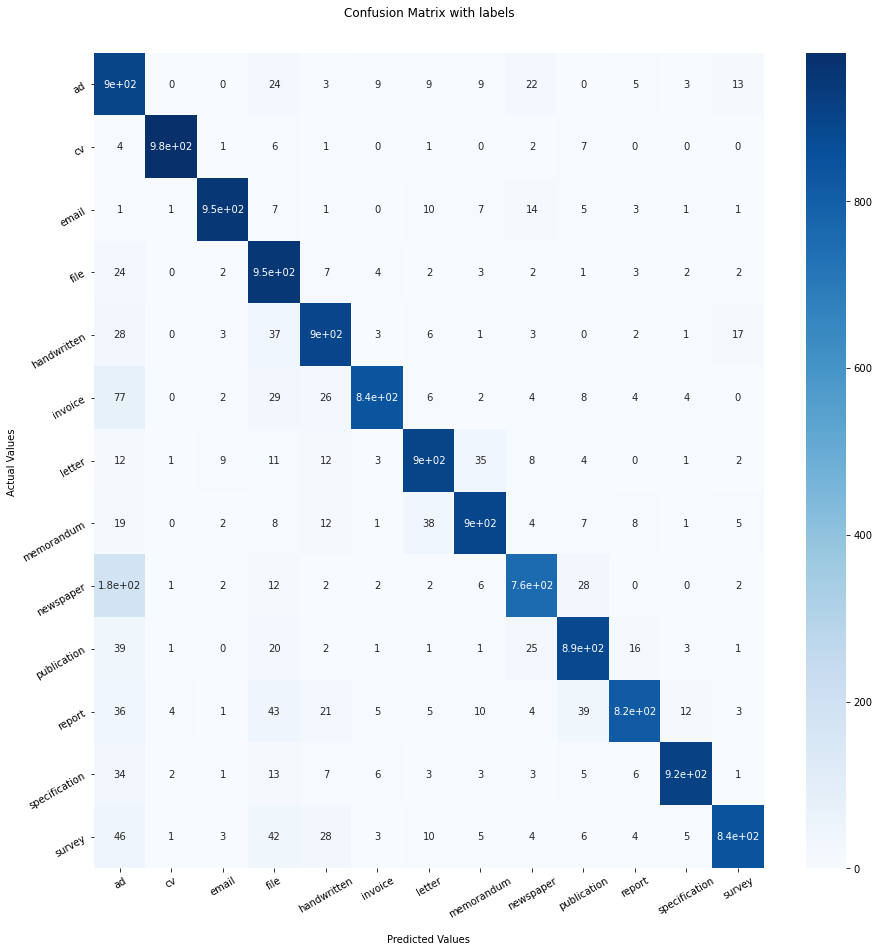

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual, preds)

plt.figure(figsize = (15,15))
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 10)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(os.listdir('../img/train/'))
ax.yaxis.set_ticklabels(os.listdir('../img/train/'))

## Display the visualization of the Confusion Matrix.
plt.show()

### `Classification report` for text data

In [12]:
from sklearn.metrics import classification_report

print(classification_report(actual, preds,
                            target_names= ['ad', 'cv', 'email', 'file', 'handwritten',
                                           'invoice', 'letter', 'memorandum', 'newspaper',
                                           'publication', 'report', 'specification', 'survey']))

               precision    recall  f1-score   support

           ad       0.64      0.90      0.75      1000
           cv       0.99      0.98      0.98      1000
        email       0.97      0.95      0.96      1000
         file       0.79      0.95      0.86      1000
  handwritten       0.88      0.90      0.89      1000
      invoice       0.96      0.84      0.89      1000
       letter       0.91      0.90      0.90      1000
   memorandum       0.92      0.90      0.91      1000
    newspaper       0.89      0.76      0.82      1000
  publication       0.89      0.89      0.89      1000
       report       0.94      0.82      0.87      1000
specification       0.97      0.92      0.94      1000
       survey       0.95      0.84      0.89      1000

     accuracy                           0.89     13000
    macro avg       0.90      0.89      0.89     13000
 weighted avg       0.90      0.89      0.89     13000



### Thanks